In [1]:
import tensorflow as tf
from censai import RayTracer, AnalyticalPhysicalModel, PhysicalModel
from censai.data.alpha_tng import decode_train, decode_physical_info
from censai.utils import nullwriter, plot_to_image, raytracer_residual_plot as residual_plot
import os, glob
import numpy as np
from datetime import datetime
import random, time
from argparse import ArgumentParser
import json
from tensorboard.plugins.hparams import api as hp
gpus = tf.config.list_physical_devices('GPU')

""" # NOTE ON THE USE OF MULTIPLE GPUS #
Double the number of gpus will not speed up the code. In fact, doubling the number of gpus and mirroring 
the ops accross replicas means the code is TWICE as slow.

In fact, using multiple gpus means one should at least multiply the batch size by the number of gpus introduced, 
and optimize hyperparameters accordingly (learning rate should be scaled similarly).
"""
if len(gpus) == 1:
    STRATEGY = tf.distribute.OneDeviceStrategy(device="/gpu:0")
elif len(gpus) > 1:
    STRATEGY = tf.distribute.MirroredStrategy()
wndb = False

In [2]:
# import tensorflow as tf
# from censai.models.layers import UnetDecodingLayer, UnetEncodingLayer
# from censai.definitions import logkappa_normalization, log_kappa
# from censai.models.utils import get_activation


# class RayTracer(tf.keras.Model):
#     def __init__(
#             self,
#             pixels,
#             filter_scaling=1,
#             layers=4,
#             block_conv_layers=2,
#             kernel_size=3,
#             filters=32,
#             strides=2,
#             bottleneck_filters=None,
#             resampling_kernel_size=None,
#             upsampling_interpolation=False,     # use strided transposed convolution if false
#             kernel_regularizer_amp=0.,
#             bias_regularizer_amp=0.,            # if bias is used
#             activation="linear",
#             initializer="random_uniform",
#             use_bias=False,
#             kappalog=True,
#             normalize=False,
#             trainable=True,
#             name="ray_tracer",
#     ):
#         super(RayTracer, self).__init__(name=name)
#         self.trainable = trainable
#         self.kappalog = kappalog
#         self.kappa_normalize = normalize

#         common_params = {"padding": "same", "kernel_initializer": initializer,
#                          "data_format": "channels_last", "use_bias": use_bias,
#                          "kernel_regularizer": tf.keras.regularizers.L2(l2=kernel_regularizer_amp)}
#         if use_bias:
#             common_params.update({"bias_regularizer": tf.keras.regularizers.L2(l2=bias_regularizer_amp)})

#         resampling_kernel_size = resampling_kernel_size if resampling_kernel_size is not None else kernel_size
#         bottleneck_filters = bottleneck_filters if bottleneck_filters is not None else int(filter_scaling**(layers) * filters)

#         activation = get_activation(activation)

#         # compute size of bottleneck here
#         bottleneck_size = pixels // strides**(layers)

#         self.encoding_layers = []
#         self.decoding_layers = []
#         for i in range(layers):
#             self.encoding_layers.append(UnetEncodingLayer(
#                 kernel_size=kernel_size,
#                 downsampling_kernel_size=resampling_kernel_size,
#                 filters=int(filter_scaling**(i) * filters),
#                 strides=strides,
#                 conv_layers=block_conv_layers,
#                 activation=activation,
#                 **common_params
#             ))
#             self.decoding_layers.append(UnetDecodingLayer(
#                 kernel_size=kernel_size,
#                 upsampling_kernel_size=resampling_kernel_size,
#                 filters=int(filter_scaling**(i) * filters),
#                 conv_layers=block_conv_layers,
#                 strides=strides,
#                 activation=activation,
#                 bilinear=upsampling_interpolation,
#                 **common_params
#             ))

#         # reverse decoding layers order
#         self.decoding_layers = self.decoding_layers[::-1]

#         self.bottleneck_layer1 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=2*bottleneck_size,  # we perform a convolution over the full image at this point,
#             activation="linear",
#             **common_params
#         )
#         self.bottleneck_layer2 = tf.keras.layers.Conv2D(
#             filters=bottleneck_filters,
#             kernel_size=2*bottleneck_size,
#             activation="linear",
#             **common_params
#         )

#         self.output_layer = tf.keras.layers.Conv2D(
#             filters=2,
#             kernel_size=(1, 1),
#             activation="linear",
#             **common_params
#         )

#         if self.kappalog:
#             if self.kappa_normalize:
#                 self.kappa_link = tf.keras.layers.Lambda(lambda x: log_kappa(logkappa_normalization(x, forward=True)))
#             else:
#                 self.kappa_link = tf.keras.layers.Lambda(lambda x: log_kappa(x))
#         else:
#             self.kappa_link = tf.keras.layers.Lambda(lambda x: x)

#     def __call__(self, kappa):
#         return self.call(kappa)

#     def call(self, kappa):
#         kappa = self.kappa_link(kappa)
#         skip_connections = []
#         z = kappa
#         for i in range(len(self.encoding_layers)):
#             c_i, z = self.encoding_layers[i](z)
#             skip_connections.append(c_i)
#         skip_connections = skip_connections[::-1]
#         z = self.bottleneck_layer1(z)
#         z = self.bottleneck_layer2(z)
#         for i in range(len(self.decoding_layers)):
#             z = self.decoding_layers[i](z, skip_connections[i])
#         z = self.output_layer(z)
#         return z

#     def cost(self, kappa, alpha_true):
#         alpha_pred = self.call(kappa)
#         return tf.reduce_mean((alpha_pred - alpha_true) ** 2)


In [13]:

RAYTRACER_HPARAMS = [
    "pixels",
    "filter_scaling",
    "layers",
    "block_conv_layers",
    "kernel_size",
    "filters",
    "strides",
    "bottleneck_filters",
    "resampling_kernel_size",
    "upsampling_interpolation",
    "kernel_regularizer_amp",
    "activation",
    "initializer",
    "kappalog",
    "normalize",
]


def main(args):
    if wndb:
        config = wandb.config
        config.update(vars(args))
    # ========= Dataset=================================================================================================
    files = []
    for dataset in args.datasets:
        files.extend(glob.glob(os.path.join(dataset, "*.tfrecords")))
    random.shuffle(files)
    files = tf.data.Dataset.from_tensor_slices(files)
    dataset = files.interleave(lambda x: tf.data.TFRecordDataset(x, num_parallel_reads=args.num_parallel_reads, compression_type=args.compression_type),
                               cycle_length=args.cycle_length, block_length=args.block_length)
        # extract physical info from first example
    for image_fov, kappa_fov in dataset.map(decode_physical_info):
        break
    dataset = dataset.map(decode_train).batch(args.batch_size)
    if args.cache_file is not None:
        dataset = dataset.cache(args.cache_file).prefetch(tf.data.experimental.AUTOTUNE)
    else:  # do not cache if no file is provided, dataset is huge and does not fit in GPU or RAM
        dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    train_dataset = dataset.take(int(args.train_split * args.total_items) // args.batch_size) # dont forget to divide by batch size!
    val_dataset = dataset.skip(int(args.train_split * args.total_items) // args.batch_size)
    val_dataset = val_dataset.take(int((1 - args.train_split) * args.total_items) // args.batch_size)
    train_dataset = STRATEGY.experimental_distribute_dataset(train_dataset)
    val_dataset = STRATEGY.experimental_distribute_dataset(val_dataset)

    # ========== Model and Physical Model =============================================================================
    # setup an analytical physical model to compare lenses from raytracer and analytical deflection angles.
    phys = PhysicalModel(pixels=args.pixels, image_fov=image_fov, kappa_fov=kappa_fov, src_fov=2, psf_sigma=0.04)
    with STRATEGY.scope():  # Replicate ops accross gpus
        ray_tracer = RayTracer(
            pixels=args.pixels,
            filter_scaling=args.filter_scaling,
            layers=args.layers,
            block_conv_layers=args.block_conv_layers,
            kernel_size=args.kernel_size,
            filters=args.filters,
            strides=args.strides,
            bottleneck_filters=args.bottleneck_filters,
            resampling_kernel_size=args.resampling_kernel_size,
            upsampling_interpolation=args.upsampling_interpolation,
            kernel_regularizer_amp=args.kernel_regularizer_amp,
            activation=args.activation,
            initializer=args.initializer,
            kappalog=args.kappalog,
            normalize=args.normalize,
        )

        lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
            args.initial_learning_rate,
            decay_steps=args.decay_steps,
            decay_rate=args.decay_rate,
            staircase=True)
        optim = tf.keras.optimizers.Adam(learning_rate=lr_schedule, beta_1=0.9, beta_2=0.999)

    # ==== Take care of where to write logs and stuff =================================================================
    if args.model_id.lower() != "none":
        logname = args.model_id
    elif args.logname is not None:
        logname = args.logname
    else:
        logname = args.logname_prefixe + "_" + datetime.now().strftime("%y-%m-%d_%H-%M-%S")
    # setup tensorboard writer (nullwriter in case we do not want to sync)
    if args.logdir.lower() != "none":
        logdir = os.path.join(args.logdir, logname)
        traindir = os.path.join(logdir, "train")
        testdir = os.path.join(logdir, "test")
        if not os.path.isdir(logdir):
            os.mkdir(logdir)
        if not os.path.isdir(traindir):
            os.mkdir(traindir)
        if not os.path.isdir(testdir):
            os.mkdir(testdir)
        train_writer = tf.summary.create_file_writer(traindir)
        test_writer = tf.summary.create_file_writer(testdir)
    else:
        train_writer = nullwriter()
        test_writer = nullwriter()
    # ===== Make sure directory and checkpoint manager are created to save model ===================================
    if args.model_dir.lower() != "none":
        checkpoints_dir = os.path.join(args.model_dir, logname)
        if not os.path.isdir(checkpoints_dir):
            os.mkdir(checkpoints_dir)
            # save script parameter for future reference
            import json
            with open(os.path.join(checkpoints_dir, "script_params.json"), "w") as f:
                json.dump(vars(args), f)
            with open(os.path.join(checkpoints_dir, "ray_tracer_hparams.json"), "w") as f:
                hparams_dict = {key: vars(args)[key] for key in RAYTRACER_HPARAMS}
                json.dump(hparams_dict, f)
        ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optim, net=ray_tracer)
        checkpoint_manager = tf.train.CheckpointManager(ckpt, checkpoints_dir, max_to_keep=args.max_to_keep)
        save_checkpoint = True
        # ======= Load model if model_id is provided ===============================================================
        if args.model_id.lower() != "none":
            if args.load_checkpoint == "lastest":
                checkpoint_manager.checkpoint.restore(checkpoint_manager.latest_checkpoint)
            elif args.load_checkpoint == "best":
                scores = np.loadtxt(os.path.join(checkpoints_dir, "score_sheet.txt"))
                _checkpoint = scores[np.argmin(scores[:, 1]), 0]
                checkpoint = checkpoint_manager.checkpoints[_checkpoint]
                checkpoint_manager.checkpoint.restore(checkpoint)
            else:
                checkpoint = checkpoint_manager.checkpoints[int(args.load_checkpoint)]
                checkpoint_manager.checkpoint.restore(checkpoint)
    else:
        save_checkpoint = False
    # =================================================================================================================
    def train_step(inputs):
        kappa, alpha = inputs
        with tf.GradientTape(watch_accessed_variables=True) as tape:
            tape.watch(ray_tracer.trainable_weights)
#             cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha), axis=(1, 2, 3))
            cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha), axis=(1, 2, 3))
            cost = tf.reduce_sum(cost) / args.batch_size    # normalize by global batch size
        gradient = tape.gradient(cost, ray_tracer.trainable_weights)
        if args.clipping:
            clipped_gradient = [tf.clip_by_value(grad, -10, 10) for grad in gradient]
        else:
            clipped_gradient = gradient
        optim.apply_gradients(zip(clipped_gradient, ray_tracer.trainable_variables))
        return cost

    @tf.function
    def distributed_train_step(dist_inputs):
        per_replica_losses = STRATEGY.run(train_step, args=(dist_inputs,))
        cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        cost += tf.reduce_sum(ray_tracer.losses)
        return cost

    def test_step(inputs):
        kappa, alpha = inputs
        cost = tf.reduce_mean(tf.square(ray_tracer(kappa) - alpha), axis=(1, 2, 3))
        cost = tf.reduce_sum(cost) / args.batch_size    # normalize by global batch size
        return cost

    @tf.function
    def distributed_test_step(dist_inputs):
        per_replica_losses = STRATEGY.run(test_step, args=(dist_inputs,))
        # Replica losses are aggregated by summing them
        cost = STRATEGY.reduce(tf.distribute.ReduceOp.SUM, per_replica_losses, axis=None)
        cost += tf.reduce_sum(ray_tracer.losses)
        return cost
    # =================================================================================================================
    epoch_loss = tf.metrics.Mean()
    val_loss = tf.metrics.Mean()
    time_per_step = tf.metrics.Mean()
    best_loss = np.inf
    patience = args.patience
    step = 1
    lastest_checkpoint = 1
    for epoch in range(1, args.epochs + 1):
        epoch_loss.reset_states()
        time_per_step.reset_states()
        with train_writer.as_default():
            for batch, distributed_inputs in enumerate(train_dataset):
                start = time.time()
                cost = distributed_train_step(distributed_inputs)
        # ========== Summary and logs ==================================================================================
                _time = time.time() - start
                tf.summary.scalar("Time per step", _time, step=step)
                time_per_step.update_state([_time])
                epoch_loss.update_state([cost])
                tf.summary.scalar("MSE", cost, step=step)
                step += 1
            tf.summary.scalar("Learning rate", optim.lr(step), step=step)
            # last batch we make a summary of residuals
            for res_idx in range(min(args.n_residuals, args.batch_size)):
                # Deflection angle residual
                alpha_true = distributed_inputs[1][res_idx, ...]
                alpha_pred = ray_tracer.call(distributed_inputs[0][res_idx, ...][None, ...])[0, ...]
                # Lens residual
                kappa = distributed_inputs[0][res_idx, ...][None, ...]
                lens_true = phys.lens_source_func(kappa)[0, ...]
                lens_pred = phys.lens_source_func_given_alpha(alpha_pred, w=args.source_w)[0, ...]
                tf.summary.image(f"Residuals {res_idx}",
                                 plot_to_image(residual_plot(alpha_true, alpha_pred, lens_true, lens_pred)), step=step)
#         if args.profile and epoch == 1:
#             # redo the last training step for debugging purposes
#             tf.profiler.experimental.start(logdir=logdir)
#             cost = distributed_train_step(distributed_inputs)
#             tf.profiler.experimental.stop()
#         with test_writer.as_default():
#             val_loss.reset_states()
#             for distributed_inputs in val_dataset:
#                 test_cost = distributed_test_step(distributed_inputs)
#                 val_loss.update_state([test_cost])
#             for res_idx in range(min(args.n_residuals, args.batch_size)):
#                 y_true = distributed_inputs[1][res_idx, ...]
#                 y_pred = ray_tracer.call(distributed_inputs[0][res_idx, ...][None, ...])[0, ...]
#                 tf.summary.image(f"Residual {res_idx}", plot_to_image(residual_plot(y_true, y_pred)), step=step)
#             # Lens residual
#             for ellipticity in [0., 0.1, 0.4, 0.6]:
#                 lens_true = phys.lens_source_func(e=ellipticity)[0, ...]
#                 alpha_pred = ray_tracer(phys.kappa_field(e=ellipticity))
#                 lens_pred = phys.lens_source_func_given_alpha(alpha_pred)[0, ...]
#                 tf.summary.image(f"Lens residual with ellipticity={ellipticity}",
#                                  plot_to_image(lens_residual_plot(lens_true, lens_pred, title=rf"$e = {ellipticity}$")), step=step)
        train_cost = epoch_loss.result().numpy()
        val_cost = train_cost
#         val_cost = val_loss.result().numpy()
#         print(f"epoch {epoch} | train loss {train_cost:.3e} | val loss {val_cost:.3e} | learning rate {optim.lr(step).numpy():.2e} | "
#               f"time per step {time_per_step.result():.2e} s")
        print(f"epoch {epoch} | train loss {train_cost:.3e} | learning rate {optim.lr(step).numpy():.2e} | "
              f"time per step {time_per_step.result():.2e} s")
        # =============================================================================================================
        if val_cost < best_loss * (1 - args.tolerance):
            best_loss = val_cost
            patience = args.patience
        else:
            patience -= 1

        if save_checkpoint:
            checkpoint_manager.checkpoint.step.assign_add(1)  # a bit of a hack
            if epoch % args.checkpoints == 0 or patience == 0 or epoch == args.epochs - 1:
                with open(os.path.join(checkpoints_dir, "score_sheet.txt"), mode="a") as f:
                    np.savetxt(f, np.array([[lastest_checkpoint, val_cost]]))
                lastest_checkpoint += 1
                checkpoint_manager.save()
                print("Saved checkpoint for step {}: {}".format(int(checkpoint_manager.checkpoint.step), checkpoint_manager.latest_checkpoint))
        if patience == 0:
            print("Reached patience")
            break
#     # at the end of training, log hyperparameters for future tuning
    with tf.summary.create_file_writer(os.path.join(args.logdir, args.logname_prefixe + "_hparams", logname)).as_default():
        hparams_dict = {key: vars(args)[key] for key in RAYTRACER_HPARAMS}
        hparams_dict = {k: (str(v) if v is None else v) for k,v in hparams_dict.items()}
        print(hparams_dict)
        hp.hparams(hparams_dict)
        tf.summary.scalar("Test MSE", best_loss, step=step)
        tf.summary.scalar("Final Train MSE", train_cost, step=step)
    return ray_tracer, phys, train_dataset, dataset

In [14]:
date = datetime.now().strftime("%y-%m-%d_%H-%M-%S")
parser = ArgumentParser()
parser.add_argument("--model_id",                   default="None",              help="Start training from previous "
                                                                                      "checkpoint of this model if provided")
parser.add_argument("--load_checkpoint",            default="best",              help="One of 'best', 'lastest' or the specific checkpoint index")
parser.add_argument("--datasets",                   required=True,  nargs="+",   help="Datasets to use, paths that contains tfrecords of dataset. User can provide multiple "
                                                                                      "directories to mix datasets")
parser.add_argument("--compression_type",           default=None,                help="Compression type used to write data. Default assumes no compression.")

# Model hyper parameters
parser.add_argument("--pixels",                         required=True,            type=int,     help="Size of input tensors, need to match dataset size!!")
parser.add_argument("--kernel_size",                    default=3,                type=int,     help="Main kernel size of U-net")
parser.add_argument("--filters",                        default=32,               type=int,     help="Number of filters of conv layers")
parser.add_argument("--filter_scaling",                 default=1,                type=float,   help="Scaling of the number of filters at each layers (1=no scaling)")
parser.add_argument("--layers",                         default=2,                type=int,     help="Number of layers of Unet (number of downsampling and upsampling")
parser.add_argument("--block_conv_layers",              default=2,                type=int,     help="Number of convolutional layers in a unet layer")
parser.add_argument("--strides",                        default=2,                type=int,     help="Strides of downsampling and upsampling layers")
parser.add_argument("--bottleneck_filters",             default=None,             type=int,     help="Number of filters of bottleneck layers. Default None, use normal scaling of filters.")
parser.add_argument("--resampling_kernel_size",         default=None,             type=int,     help="Kernel size of downsampling and upsampling layers. None, use same kernel size as the others.")
parser.add_argument("--upsampling_interpolation",       action="store_true",                    help="True: Use Bilinear interpolation for upsampling, False use Fractional Striding Convolution")
parser.add_argument("--kernel_regularizer_amp",         default=1e-3,             type=float,   help="l2 regularization on weights")
parser.add_argument("--kappalog",                       action="store_true",                    help="Input is log of kappa")
parser.add_argument("--normalize",                      action="store_true",                    help="Normalize log of kappa with max and minimum values defined in definitions.py")
parser.add_argument("--activation",                     default="linear",         type=str,     help="Non-linearity of layers")
parser.add_argument("--initializer",                    default="glorot_uniform", type=str,     help="Weight initializer")

# Training set params
parser.add_argument("-b", "--batch_size",               default=10,     type=int,               help="Number of images in a batch")
parser.add_argument("--train_split",                    default=0.8,    type=float,             help="Fraction of the training set")
parser.add_argument("--total_items",                    required=True,  type=int,               help="Total images in an epoch.")
# ... for tfrecord dataset
parser.add_argument("--num_parallel_reads",             default=10,     type=int,               help="TFRecord dataset number of parallel reads when loading data")
parser.add_argument("--cache_file",                     default=None,                           help="Path to cache file, useful when training on server. Use ${SLURM_TMPDIR}/cache")
parser.add_argument("--cycle_length",                   default=4,      type=int,               help="Number of files to read concurrently.")
parser.add_argument("--block_length",                   default=1,      type=int,               help="Number of example to read from each files.")

# Logs
parser.add_argument("--logdir",                         default="None",                         help="Path of logs directory.")
parser.add_argument("--logname",                        default=None,                           help="Name of the logs, default is 'RT_' + date")
parser.add_argument("--logname_prefixe",                default="RayTracer",                    help="If name of the log is not provided, this prefix is prepended to the date")
parser.add_argument("--model_dir",                      default="None",                         help="Directory where to save model weights")
parser.add_argument("--checkpoints",                    default=10,     type=int,               help="Save a checkpoint of the models each {%} iteration")
parser.add_argument("--max_to_keep",                    default=3,      type=int,               help="Max model checkpoint to keep")
parser.add_argument("--n_residuals",                    default=1,      type=int,               help="Number of residual plots to save. Add overhead at the end of an epoch only.")
parser.add_argument("--profile",                        action="store_true",                    help="If added, we will profile the last training step of the first epoch")

# Optimization params
parser.add_argument("-e", "--epochs",                   default=10,     type=int,               help="Number of epochs for training.")
parser.add_argument("--initial_learning_rate",          default=1e-3,   type=float,             help="Initial learning rate.")
parser.add_argument("--decay_rate",                     default=1.,     type=float,             help="Exponential decay rate of learning rate (1=no decay).")
parser.add_argument("--decay_steps",                    default=1000,   type=int,               help="Decay steps of exponential decay of the learning rate.")
parser.add_argument("--clipping",                       action="store_true",                    help="Clip backprop gradients between -10 and 10")
parser.add_argument("--patience",                       default=np.inf, type=int,               help="Number of step at which training is stopped if no improvement is recorder")
parser.add_argument("--tolerance",                      default=0,      type=float,             help="Current score <= (1 - tolerance) * best score => reset patience, else reduce patience.")

# Reproducibility params
parser.add_argument("--seed",                           default=None,   type=int, help="Random seed for numpy and tensorflow")
parser.add_argument("--json_override",                  default=None,             help="A json filepath that will override every command line parameters. "
                                                                                       "Useful for reproducibility")


_StoreAction(option_strings=['--json_override'], dest='json_override', nargs=None, const=None, default=None, type=None, choices=None, help='A json filepath that will override every command line parameters. Useful for reproducibility', metavar=None)

In [15]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 {os.getenv('HOME')}/scratch/Censai/data/alpha128_NIS "\
  f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_NIS "\
  f"--total_items=1 "\
  f"--epochs=50 "\
  f"--train_split=1 "\
  f"--compression_type=GZIP "\
  f"--pixels=128 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=100 "\
  f"--kernel_size=5 "\
  f"--filters=82 "\
  f"--filter_scaling=1 "\
  f"--layers=4 "\
  f"--block_conv_layers=2 "\
  f"--strides=2 "\
  f"--resampling_kernel_size=7 "\
  f"--kappalog "\
#   f"--normalize "\
  f"--upsampling_interpolation "\
  f"--clipping "\
  f"--kernel_regularizer_amp=0 "\
  f"--initializer=glorot_uniform "\
  f"--batch_size=1 "\
  f"--num_parallel_reads=1 "\
  f"--cycle_length=1 "\
  f"--block_length=1 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RayTracer128_Interactive "\
#   f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
#   f"--checkpoints=5 "\
#   f"--max_to_keep=10 "\
  f"--n_residuals=0 "\
  f"--patience=50 "\
  f"--tolerance=0.01 "\
  f"--seed=32 ".split()
)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
ray_tracer, phys, train_dataset, dataset = main(args)

epoch 1 | train loss 4.413e+00 | learning rate 1.00e-04 | time per step 1.03e+00 s
epoch 2 | train loss 3.619e+00 | learning rate 1.00e-04 | time per step 5.62e-03 s
epoch 3 | train loss 1.051e+01 | learning rate 1.00e-04 | time per step 5.57e-03 s
epoch 4 | train loss 2.535e+00 | learning rate 1.00e-04 | time per step 5.51e-03 s
epoch 5 | train loss 3.180e+00 | learning rate 1.00e-04 | time per step 5.37e-03 s
epoch 6 | train loss 2.812e+00 | learning rate 1.00e-04 | time per step 5.39e-03 s
epoch 7 | train loss 2.067e+00 | learning rate 1.00e-04 | time per step 5.56e-03 s
epoch 8 | train loss 4.607e+00 | learning rate 1.00e-04 | time per step 5.37e-03 s
epoch 9 | train loss 2.443e+00 | learning rate 1.00e-04 | time per step 5.43e-03 s
epoch 10 | train loss 3.392e+00 | learning rate 1.00e-04 | time per step 5.42e-03 s
epoch 11 | train loss 3.681e+00 | learning rate 1.00e-04 | time per step 5.38e-03 s
epoch 12 | train loss 3.581e+00 | learning rate 1.00e-04 | time per step 5.52e-03 s
e

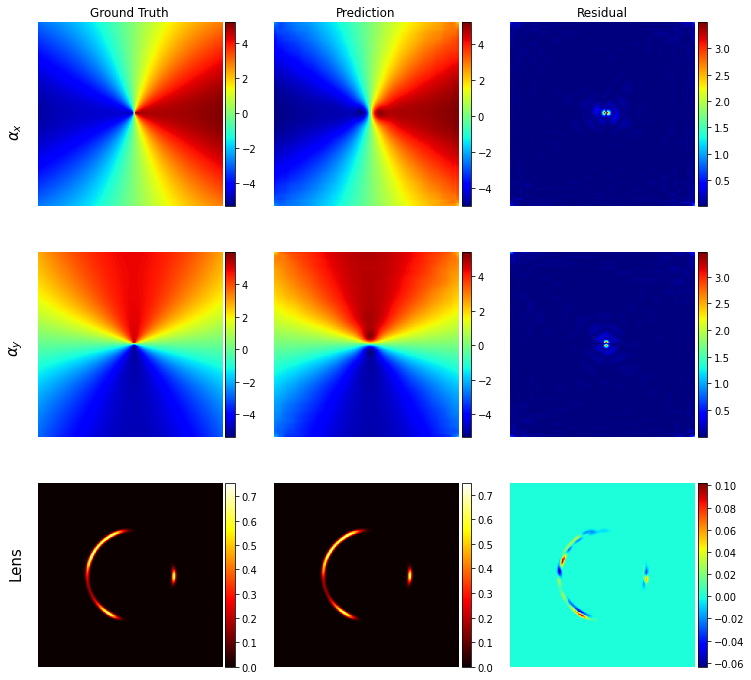

In [6]:
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        # Deflection angle residual
        alpha_true = distributed_inputs[1][res_idx, ...]
        alpha_pred = ray_tracer.call(distributed_inputs[0][res_idx, ...][None, ...])[0, ...]
        # Lens residual
        kappa = distributed_inputs[0][res_idx, ...][None, ...]
        lens_true = phys.lens_source_func(kappa)[0, ...]
        lens_pred = phys.lens_source_func_given_alpha(alpha_pred)[0, ...]
        residual_plot(alpha_true, alpha_pred, lens_true, lens_pred)
    break

In [7]:
import sys
sys.argv = ['']
args = parser.parse_args(
#   f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 {os.getenv('HOME')}/scratch/Censai/data/alpha128_NIS "\
  f"--datasets {os.getenv('HOME')}/scratch/Censai/data/alpha128_TNG100 "\
  f"--total_items=1000 "\
  f"--epochs=50 "\
  f"--train_split=1 "\
  f"--compression_type=GZIP "\
  f"--pixels=128 "\
  f"--initial_learning_rate=1e-4 "\
  f"--decay_rate=0.9 "\
  f"--decay_steps=100 "\
  f"--kernel_size=5 "\
  f"--filters=82 "\
  f"--filter_scaling=1 "\
  f"--layers=4 "\
  f"--block_conv_layers=2 "\
  f"--strides=2 "\
  f"--resampling_kernel_size=7 "\
  f"--kappalog "\
#   f"--normalize "\
  f"--upsampling_interpolation "\
  f"--clipping "\
  f"--kernel_regularizer_amp=0 "\
  f"--initializer=glorot_uniform "\
  f"--batch_size=10 "\
  f"--num_parallel_reads=5 "\
  f"--cycle_length=5 "\
  f"--block_length=2 "\
  f"--cache_file={os.getenv('SLURM_TMPDIR')}/cache "\
  f"--logdir={os.getenv('HOME')}/scratch/Censai/logs "\
  f"--logname_prefixe=RayTracer128_Interactive "\
  f"--model_dir={os.getenv('HOME')}/scratch/Censai/models "\
  f"--checkpoints=5 "\
  f"--max_to_keep=10 "\
  f"--n_residuals=5 "\
  f"--patience=50 "\
  f"--tolerance=0.01 "\
  f"--seed=32 ".split()
)
cache_files = glob.glob(f"{os.getenv('SLURM_TMPDIR')}/cache*")
for cache in cache_files:
    os.remove(cache)
ray_tracer, phys, train_dataset, dataset = main(args)

epoch 1 | train loss 5.238e+00 | learning rate 1.00e-04 | time per step 1.23e+00 s
epoch 2 | train loss 4.723e+00 | learning rate 1.00e-04 | time per step 1.60e-02 s
epoch 3 | train loss 4.392e+00 | learning rate 1.00e-04 | time per step 7.07e-03 s
epoch 4 | train loss 3.965e+00 | learning rate 1.00e-04 | time per step 7.16e-03 s
epoch 5 | train loss 4.327e+00 | learning rate 1.00e-04 | time per step 7.08e-03 s
epoch 6 | train loss 4.125e+00 | learning rate 1.00e-04 | time per step 7.24e-03 s
epoch 7 | train loss 3.303e+00 | learning rate 1.00e-04 | time per step 7.03e-03 s
epoch 8 | train loss 3.132e+00 | learning rate 1.00e-04 | time per step 7.30e-03 s
epoch 9 | train loss 1.973e+00 | learning rate 1.00e-04 | time per step 7.21e-03 s
epoch 10 | train loss 1.434e+00 | learning rate 1.00e-04 | time per step 7.10e-03 s
epoch 11 | train loss 1.694e+00 | learning rate 1.00e-04 | time per step 7.16e-03 s
epoch 12 | train loss 1.181e+00 | learning rate 1.00e-04 | time per step 7.23e-03 s
e

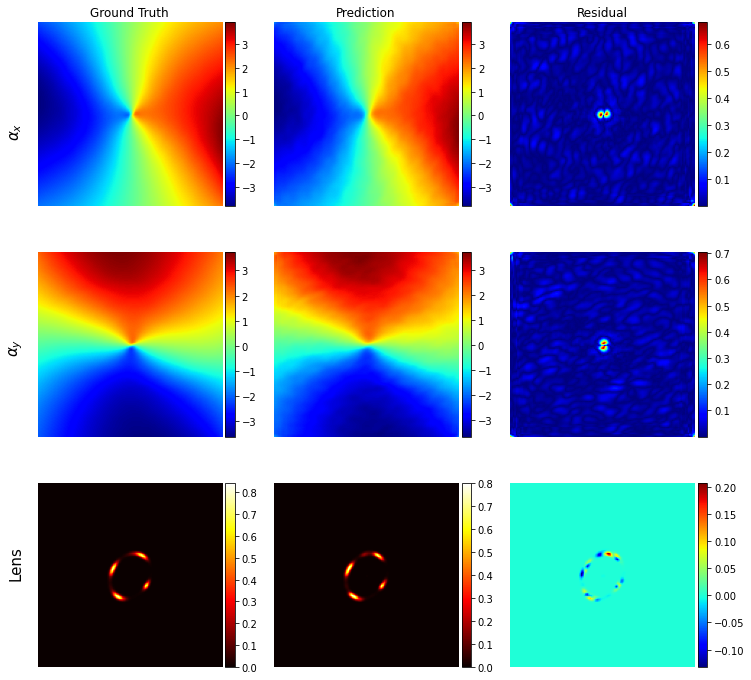

In [8]:
for batch, distributed_inputs in enumerate(train_dataset):
    for res_idx in range(args.batch_size):
        # Deflection angle residual
        alpha_true = distributed_inputs[1][res_idx, ...]
        alpha_pred = ray_tracer.call(distributed_inputs[0][res_idx, ...][None, ...])[0, ...]
        # Lens residual
        kappa = distributed_inputs[0][res_idx, ...][None, ...]
        lens_true = phys.lens_source_func(kappa)[0, ...]
        lens_pred = phys.lens_source_func_given_alpha(alpha_pred)[0, ...]
        residual_plot(alpha_true, alpha_pred, lens_true, lens_pred)
    break